# CSE 5524 Computer Vision



### Name:Yathish
### OSU Email:shiradanahallimahadevappa.1@buckeyemail.osu.edu




**Making PyTorch Deterministic**



In [1]:
## Standard libraries
import os
import math
import numpy as np
import time
import random
import hashlib

# PyTorch imports
import torch
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F


## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgba
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm
import torch
print("Using torch", torch.__version__)


def make_complex(simple_seed, verbose=False):
    """Transforms a simple integer into a more complex integer using MD5.
    Args:
        simple_seed: A simple integer (e.g., [0, 15]).
        verbose: A flag that decides if the original seed, new complex seed, and binary value of the complex seed will be displayed to console.
    Returns:
        A sufficiently large integer value with a balanced mix of 0's and 1's (in binary).
    """

    # Hash the simple seed to make high complexity representation: Good Practice in (Pseudo) Random Number Generation for Bioinformatics Applications, by David Jones (http://www0.cs.ucl.ac.uk/staff/d.jones/GoodPracticeRNG.pdf)
    m = hashlib.md5(str(simple_seed).encode('UTF-8'))

    # Convert to hex string
    hex_md5 = m.hexdigest()

    # Seed must be in range [0, 2**32 - 1], take last 32 bits (8 values * 4 bits per value = 32 bits)
    least_significant_32bits = hex_md5[-8:]

    # Convert hex to base 10
    complex_seed = int(least_significant_32bits, base=16)

    # If we want verbosity, display the value
    if verbose:
        print(f'Original seed: { simple_seed }, Complex seed: { complex_seed }, Binary value: { bin(complex_seed)[2:].zfill(32) }')

    # simple_seed in range [0, 88265] yields unique complex_seed values
    return complex_seed

def make_deterministic(seed):
    """Sets the seed for numerous random number generators (RNGs) and sets other flags for reproducibility.
    Args:
        seed: An integer value to be used as the seed for several RNGs. This value can be a simple integer (e.g., [0, 15]) as it will be made more complex.
    """

    seed = make_complex(seed)

    # NumPy
    np.random.seed(seed)
    np.random.default_rng(seed=seed)

    # PyTorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Python / OS
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    # Set other flags
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

make_deterministic(make_complex(0))



<ipython-input-1-49de39b568a3>:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Using torch 2.5.1+cu124




**CIFAR-4 Subset Generation**

We create a custom 4-class (cat, frog, airplane, car) subset of the commonly used CIFAR-10 benchmark dataset. We create custom splits of 300 train, 100 val, and 100 test examples per class

### CIFAR-4 Susbset Dataset Class and Custom Splitting

In [30]:
make_deterministic(make_complex(0))

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

class CIFAR10Subset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image, label = self.data[idx], self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

def create_cifar10_subset_splits(train_size=1000, val_size=300, test_size=300):


    # Data transformation pipeline
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    transform_eval = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    # Load the original CIFAR-10 dataset
    cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)
    cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=None)

    # Filter the dataset to include only cat, dog, deer, and horse classes
    classes_dict = {'plane':0, 'car':1, 'bird':2, 'cat':3, 'deer':4, 'dog':5, 'frog':6, 'horse':7, 'ship':8, 'truck':9}
    class_mapping = {3: 0, 6: 1, 0: 2, 1: 3} # cat, frog, airplane, car
    filtered_train_data, filtered_train_labels = [], []
    filtered_test_data, filtered_test_labels = [], []

    for i in range(len(cifar10_train)):
        if cifar10_train.targets[i] in class_mapping.keys():
            filtered_train_data.append(cifar10_train.data[i])
            filtered_train_labels.append(class_mapping[cifar10_train.targets[i]])

    for i in range(len(cifar10_test)):
        if cifar10_test.targets[i] in class_mapping.keys():
            filtered_test_data.append(cifar10_test.data[i])
            filtered_test_labels.append(class_mapping[cifar10_test.targets[i]])

    filtered_train = CIFAR10Subset(filtered_train_data, filtered_train_labels, transform=None)
    filtered_test = CIFAR10Subset(filtered_test_data, filtered_test_labels, transform=None)

    # Create train, validation, and test splits
    train_data, val_data, test_data = [], [], []
    for class_idx in range(4):
        class_examples = [(image, label) for image, label in filtered_train if label == class_idx]
        train_data.extend(class_examples[:train_size])
        val_data.extend(class_examples[train_size:train_size+val_size])

        class_examples = [(image, label) for image, label in filtered_test if label == class_idx]
        test_data.extend(class_examples[:test_size])

    train_dataset = CIFAR10Subset([x[0] for x in train_data], [x[1] for x in train_data], transform=transform)
    val_dataset = CIFAR10Subset([x[0] for x in val_data], [x[1] for x in val_data], transform=transform_eval)
    test_dataset = CIFAR10Subset([x[0] for x in test_data], [x[1] for x in test_data], transform=transform_eval)

    return train_dataset, val_dataset, test_dataset

# Function for preparing the dataset objects and data loaders

def prepare_data():
  make_deterministic(make_complex(0))
  train_dataset, val_dataset, test_dataset = create_cifar10_subset_splits()
  print("Size of Train dataset:", len(train_dataset))
  print("Size of Val dataset:", len(val_dataset))
  print("Size of Test dataset:", len(test_dataset))

  train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)
  val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=100, shuffle=False, num_workers=2)
  test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

  return train_dataset, train_data_loader, val_dataset, val_data_loader, test_dataset, test_data_loader

In [31]:
# Prepare data for loading
train_dataset, train_data_loader, val_dataset, val_data_loader, test_dataset, test_data_loader = prepare_data()

Files already downloaded and verified
Files already downloaded and verified
Size of Train dataset: 4000
Size of Val dataset: 1200
Size of Test dataset: 1200


## 1) visualizes a training minibatch of 8 examples along with the target class labels.also visualize a same-sized minibatch of examples from the validation and test splits.

In [21]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# Function to unnormalize and convert an image to a NumPy array
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

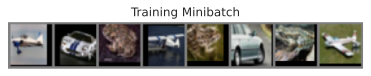

Target Labels
plane   car  frog plane  frog   car  frog plane


In [22]:
# CIFAR-10 class names
classes = ('cat', 'frog', 'plane', 'car')

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)

# Get a batch of training images and labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show images and labels
plt.title('Training Minibatch')
plt.grid(False)
plt.axis('off')
imshow(torchvision.utils.make_grid(images))
print('Target Labels')
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

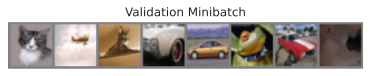

Target Labels (Validation)
  cat plane   cat   car   car  frog   car   cat


In [23]:
# Enter code to visualize Validation data

valloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True)

# Get a batch of validation images and labels
dataiter_val = iter(valloader)
images_val, labels_val = next(dataiter_val)

# Show validation images and labels
plt.title('Validation Minibatch')
plt.grid(False)
plt.axis('off')
imshow(torchvision.utils.make_grid(images_val))
print('Target Labels (Validation)')
print(' '.join('%5s' % classes[labels_val[j]] for j in range(8)))









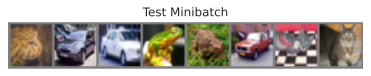

Target Labels (Test)
 frog   car   car  frog  frog   car   cat   cat


In [24]:
# Enter code to visualize Test data
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

# Get a batch of test images and labels
dataiter_test = iter(testloader)
images_test, labels_test = next(dataiter_test)

# Show test images and labels
plt.title('Test Minibatch')
plt.grid(False)
plt.axis('off')
imshow(torchvision.utils.make_grid(images_test))
print('Target Labels (Test)')
print(' '.join('%5s' % classes[labels_test[j]] for j in range(8)))








## 2) custom CNN model below that contains a ResNet style Residual block with skip connections.

In [25]:
# Define a Residual Block with skip connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()

        # 1. Add a Conv2d layer mapping in_channels to out_channels with kernel size 3, class input stride, padding 1, and no bias.
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        # 2. Add a BatchNorm2d layer with num_features as out_channels
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 3. Add a ReLU activation to perform the operation inplace
        self.relu = nn.ReLU(inplace=True)

        # 4. Add a Conv2d layer mapping out_channels to out_channels with kernel size 3, stride 1, padding 1, and no bias.
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)

        # 5. Add a BatchNorm2d layer with num_features as out_channels
        self.bn2 = nn.BatchNorm2d(out_channels)

        # The shortcut operation provided below is used to implement the skip connections
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        # 6. Apply the following order of forward operations to x: conv1 -> bn1 -> relu
        out = self.relu(self.bn1(self.conv1(x)))

        # 7. Apply the following order of forward operations to out: conv2 -> bn2
        out = self.bn2(self.conv2(out))

        # 8. Add a skip connection by adding the output from the shortcut operation on x to out features from the previous step.
        out += self.shortcut(x)

        # 9. Apply a relu on the summed out features
        out = self.relu(out)
        return out

class SimpleCustomCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(SimpleCustomCNN, self).__init__()

        # 10. Add a Conv2d layer mapping 3 input channels to 16 output channels with kernel size 3, stride 1, padding 1, and no bias.
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)

        self.in_channels = 16  # input channel size after conv1

        # 11. Add a BatchNorm2d layer with num_features as 16
        self.bn1 = nn.BatchNorm2d(16)

        # 12. Add a ReLU activation to perform the operation inplace
        self.relu = nn.ReLU(inplace=True)

        # The lines below add 2 residual block layers to the custom CNN
        self.layer1 = self._make_layer(16, 1, stride=1)
        self.layer2 = self._make_layer(32, 1, stride=2)

        # 13. Add a 2D adaptive average pooling layer with output_size set to 1 to flatten the feature maps before the fully connected layers
        self.avg_pool = nn.AdaptiveAvgPool2d(1)

        # 14. Add a linear layer that maps the flattened feature map size (calculate this) to the number of target classes.
        self.fc = nn.Linear(32, num_classes)

    def _make_layer(self, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(ResidualBlock(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # 15. Apply the following order of forward operations to x: conv1 -> bn1 -> relu
        out = self.relu(self.bn1(self.conv1(x)))
        # 16. Apply layer1 to out
        out = self.layer1(out)
        # 17. Apply layer2 to out
        out = self.layer2(out)
        # 18. Apply avg_pool to out
        out = self.avg_pool(out)
        # Flatten the output features
        out = out.view(out.size(0), -1)
        # 19. Apply fc to out
        out = self.fc(out)
        return out


In [26]:


def train_val_ckp_model(model, optimizer, train_data_loader, val_data_loader, loss_module, scheduler=None, num_epochs=100):
  # Training loop
  best_epoch = 0
  best_val_acc = 0
  for epoch in tqdm(range(num_epochs)):
    # Set model to train mode
    model.train()
    for data_inputs, data_labels in train_data_loader:
      ## Step 1: Run the model on the input data
      preds = model(data_inputs)

      ## Step 2: Calculate the loss
      loss = loss_module(preds, data_labels)

      ## Step 3: Perform backpropagation
      # Before calculating the gradients, we need to ensure that they are all zero.
      # The gradients would not be overwritten, but actually added to the existing ones.
      optimizer.zero_grad()
      # Perform backpropagation
      loss.backward()

      ## Step 4: Update the parameters
      optimizer.step()
    # Take a LR scheduler step
    if scheduler is not None:
      scheduler.step()

    # Validation of model
    val_acc = validate_model(model, val_data_loader, epoch)
    # Checkpointing best model
    if val_acc >= best_val_acc:
      best_val_acc = val_acc
      best_epoch = epoch
      checkpoint_model(model, optimizer, epoch, ckp_name = 'best_val')
  print(f'Training completed. Best Val epoch checkpoint: {best_epoch} Best Val Accuracy: {100.0*best_val_acc:4.2f}%')

def validate_model(model, data_loader, epoch):
    # Always set model to eval mode when running inference on the model
    model.eval()
    # Initialize counts
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            # Evaluating the model
            preds = model(data_inputs)
            _,pred_labels = torch.max(preds, dim=1)
            true_preds += torch.sum(pred_labels==data_labels).item()
            num_preds += data_labels.shape[0]
    # Calcukate accuracy
    acc = true_preds / num_preds
    print(f"Epoch: {epoch+1} Val Accuracy of the model: {100.0*acc:4.2f}%")
    return acc

def eval_model(model, data_loader):
    model.eval() # Set model to eval mode
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:
            # Evaluating the model
            preds = model(data_inputs)
            _,pred_labels = torch.max(preds, dim=1)
            true_preds += torch.sum(pred_labels==data_labels).item()
            num_preds += data_labels.shape[0]

    acc = true_preds / num_preds
    print(f"Test Accuracy of the model: {100.0*acc:4.2f}%")



def checkpoint_model(model, optimizer, epoch, ckp_name = 'ckp'):
  torch.save({
          'epoch': epoch,
          'state_dict': model.state_dict(),
          'optimizer': optimizer.state_dict()
      }, f"{ckp_name}_model.pt")
  print(f"{ckp_name} Checkpoint saved")


def load_ckp(checkpoint_fpath, model, optimizer):
  checkpoint = torch.load(checkpoint_fpath)
  model.load_state_dict(checkpoint['state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer'])
  return model, optimizer, checkpoint['epoch']



## 5) Training the above defined SimpleCustomCNN with the following hyperparameter settings (refer Primer for example):

i. Loss Function: CrossEntropyLoss

ii. Optimizer: Stochastic Gradient Descent

iii. Initial Learning Rate: 0.3

iv. Scheduler: Cosine Annealing LR

v. Training Epochs: 50

##  And loading the best validation checkpoint model state using the checkpointing utility functions.

In [27]:
# 1. Prepare data for loading (Ensure the make_deterministic() function is called as the first step of your preparation function)
train_dataset, train_data_loader, val_dataset, val_data_loader, test_dataset, test_data_loader = prepare_data()

# 2. Create the model object
CNN_model = SimpleCustomCNN(num_classes=4)

# 3. Create the loss criterion object
CNN_loss_module = nn.CrossEntropyLoss()

# 4. Create the optimizer object
CNN_optimizer = torch.optim.SGD(CNN_model.parameters(), lr=0.3)

# 5. Create the scheduler object (if any being used if not set to None)
CNN_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(CNN_optimizer, T_max=50)  # Adjust T_max according to the number of epochs

# 6. Set Num epochs for training
num_epochs = 55

# 7. Train the model
train_val_ckp_model(CNN_model, CNN_optimizer, train_data_loader, val_data_loader, CNN_loss_module, scheduler=CNN_scheduler, num_epochs=num_epochs)

# 8. Load the best val accuracy model
CNN_model, CNN_optimizer, CNN_best_epoch = load_ckp('best_val_model.pt', CNN_model, CNN_optimizer)

# 9. Evaluate the best model on test data
eval_model(CNN_model, test_data_loader)


Files already downloaded and verified
Files already downloaded and verified
Size of Train dataset: 4000
Size of Val dataset: 1200
Size of Test dataset: 1200


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: 1 Val Accuracy of the model: 52.67%
best_val Checkpoint saved
Epoch: 2 Val Accuracy of the model: 58.08%
best_val Checkpoint saved
Epoch: 3 Val Accuracy of the model: 64.50%
best_val Checkpoint saved
Epoch: 4 Val Accuracy of the model: 61.83%
Epoch: 5 Val Accuracy of the model: 68.25%
best_val Checkpoint saved
Epoch: 6 Val Accuracy of the model: 57.83%
Epoch: 7 Val Accuracy of the model: 69.17%
best_val Checkpoint saved
Epoch: 8 Val Accuracy of the model: 68.33%
Epoch: 9 Val Accuracy of the model: 67.25%
Epoch: 10 Val Accuracy of the model: 64.00%
Epoch: 11 Val Accuracy of the model: 69.42%
best_val Checkpoint saved
Epoch: 12 Val Accuracy of the model: 75.50%
best_val Checkpoint saved
Epoch: 13 Val Accuracy of the model: 69.50%
Epoch: 14 Val Accuracy of the model: 72.58%
Epoch: 15 Val Accuracy of the model: 73.92%
Epoch: 16 Val Accuracy of the model: 76.67%
best_val Checkpoint saved
Epoch: 17 Val Accuracy of the model: 76.83%
best_val Checkpoint saved
Epoch: 18 Val Accuracy of t

<ipython-input-26-86b7bac4c690>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_fpath)


Test Accuracy of the model: 82.83%


## 6) Loading the best model from the saved checkpoint file and visualizing the Confusion Matrix for the test data.

<ipython-input-26-86b7bac4c690>:82: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_fpath)


Confusion matrix, without normalization
[[233  35  26   6]
 [ 43 251   3   3]
 [ 18   6 263  13]
 [ 10   2  41 247]]


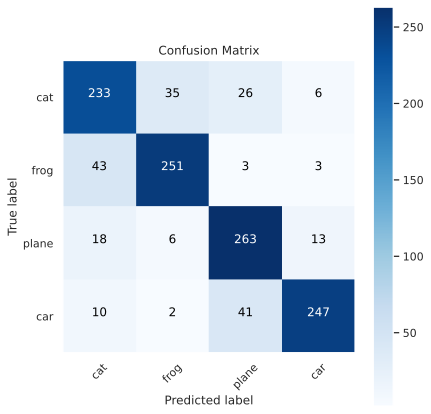

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix

device = 'cpu'

# Function to calculate the confusion matrix
def compute_confusion_matrix(net, dataloader):
    true_labels = []
    predicted_labels = []

    net.eval()
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    return confusion_matrix(true_labels, predicted_labels)



# Function to visualize the confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(6, 6))
    plt.rcParams["axes.grid"] = False
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


# Load best model from saved checkpoint file
CNN_model, CNN_optimizer, CNN_best_epoch = load_ckp('best_val_model.pt', CNN_model, CNN_optimizer)

# Compute confusion matrix
cm = compute_confusion_matrix(CNN_model, test_data_loader)
class_names = ['cat', 'frog', 'plane', 'car']

# Plot confusion matrix
plot_confusion_matrix(cm, classes=class_names, normalize=False, title='Confusion Matrix')
plt.show()
